# ***Image matching and 3D Reconstruction***

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from homography import *
from fmatrix import *
from plots import *
from utils import *
from triangulation import *

## 1) Image matching with homographies

### Implementation

Recipe to compute a homography:
- Extract local features in each image
- Match features to identify matching points
- Compute A using matching points coordinates in each image
- Find eigenvector of smallest eigenvalue of $A^\top A$
- Rearrange the vector into a 3x3 matrix

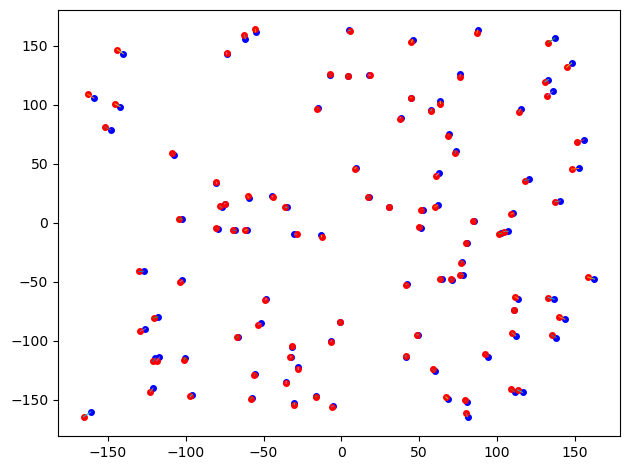

[[-5.66364526e-01 -6.02620478e-04  5.27591398e-02]
 [ 7.75531148e-04 -5.66829993e-01  1.83483946e-01]
 [-9.77732669e-05  7.96728760e-06 -5.66995699e-01]]


In [5]:
pts1, pts2, H = generate_2d_points(100, noutliers = 0, noise = 0.5, vergence = 10.0, focal = 1000)
draw_matches(pts1, pts2, img1 = None, img2 = None)
H = find_homography(pts1, pts2)
print(H)

According to the Lagrangian optimization method, we are looking for solutions of $A^\top Ah=\lambda h$. The smallest eigenvalue corresponds to the direction (in the solution space) with the least sensitivity to noise or small perturbations in the matching points. This direction is the one that minimizes the error in the least-squares sense, providing the most stable and accurate solution to the system.

### Effect of noise

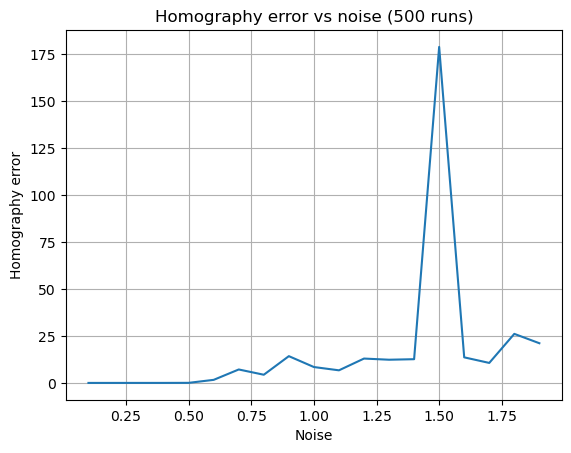

In [2]:
noise_list = np.arange(0.1, 2, 0.1).tolist()
N_runs = 500
err_run = np.zeros((N_runs, len(noise_list)))

for n in range(N_runs):
    for noise in noise_list:
        pts1, pts2, H_1 = generate_2d_points(100, noutliers = 0, noise = noise, vergence = 10.0, focal = 1000)
        H_2 = find_homography(pts1, pts2)
        err_run[n, noise_list.index(noise)] = homography_error(H_1, H_2)

err = np.mean(err_run, axis=0)

plt.plot(noise_list, err)
plt.title(f"Homography error vs noise ({N_runs} runs)")
plt.xlabel('Noise')
plt.ylabel('Homography error')
plt.grid()
plt.show()

When the noise exceeds 0.5, the error becomes significant. The more features we use when creating A, the less noise we have. To keep noise under 0.5, we should use many feature points.

### Effect of outliers

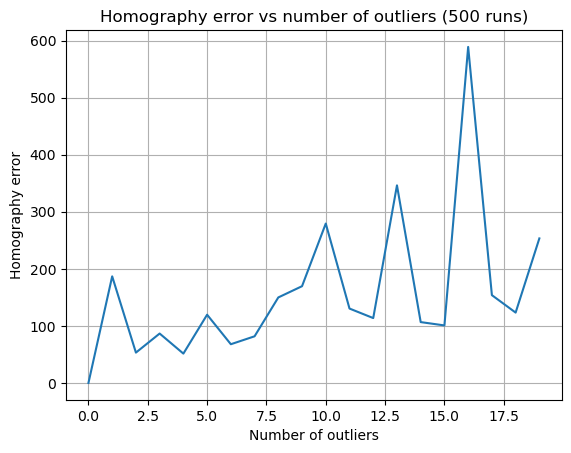

In [3]:
outliers_list = np.arange(0, 20, 1).tolist()
N_runs = 500
err_run = np.zeros((N_runs, len(outliers_list)))

for n in range(N_runs):
    for noutliers in outliers_list:
        pts1, pts2, H_1 = generate_2d_points(100, noutliers = noutliers, noise = 0.5, vergence = 10.0, focal = 1000)
        H_2 = find_homography(pts1, pts2)
        err_run[n, outliers_list.index(noutliers)] = homography_error(H_1, H_2)

err = np.mean(err_run, axis=0)

plt.plot(outliers_list, err)
plt.title(f"Homography error vs number of outliers ({N_runs} runs)")
plt.xlabel('Number of outliers')
plt.ylabel('Homography error')
plt.grid()
plt.show()

The error is highly sensitive to outliers, it starts to increase since the very first outlier and exceeds 50 after 5 outliers. We should try to keep this value as low as possible.

We are trying to minimize f(h)=|(|Ah|)|^2. When there is an outlier in A, f is quadratically affected, which strongly impacts the error.

### Filtering outliers with RANSAC

RANSAC randomly selects minimum subsets of matching points (4 points) to compute homographies. For each computed homography, RANSAC evaluates how well it fits the entire dataset by counting the number of inliers. By iterating multiple times and selecting the one with the most inliers, it ensures the homography is not built on outliers and is supported by the largest consistent set of points. 

In contrast, the original implementation without RANSAC uses all points (including outliers), which skews the estimated homography and reduces its accuracy.

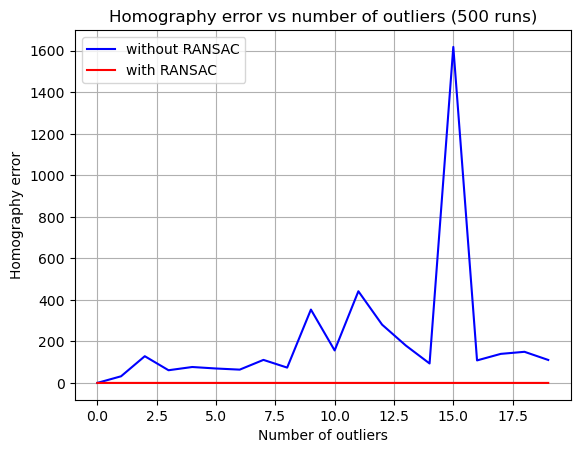

In [4]:
outliers_list = np.arange(0, 20, 1).tolist()
N_runs = 500
niter = 100
thresh = 1.0
err_run = np.zeros((N_runs, len(outliers_list)))
err_run_RANSAC = np.zeros((N_runs, len(outliers_list)))

for n in range(N_runs):
    for noutliers in outliers_list:
        pts1, pts2, H_1 = generate_2d_points(100, noutliers = noutliers, noise = 0.5, vergence = 10.0, focal = 1000)
        
        # without RANSAC
        H_2 = find_homography(pts1, pts2)
        err_run[n, outliers_list.index(noutliers)] = homography_error(H_1, H_2)

        # with RANSAC
        H_2_RANSAC = find_final_homography(pts1, pts2, niter = niter, thresh = thresh)
        err_run_RANSAC[n, outliers_list.index(noutliers)] = homography_error(H_1, H_2_RANSAC)

err = np.mean(err_run, axis=0)
err_RANSAC = np.mean(err_run_RANSAC, axis=0)


plt.plot(outliers_list, err, label='without RANSAC', color='b')
plt.plot(outliers_list, err_RANSAC, label='with RANSAC', color='r')
plt.title(f"Homography error vs number of outliers ({N_runs} runs)")
plt.xlabel('Number of outliers')
plt.ylabel('Homography error')
plt.grid()
plt.legend()
plt.show()

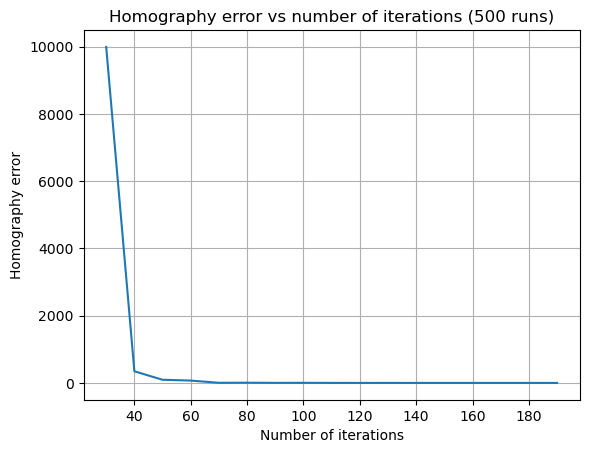

In [6]:
iterations_list = np.arange(30, 200, 10).tolist()
N_runs = 500
noutliers = 50
thresh = 1.0
err_run = np.zeros((N_runs, len(iterations_list)))
err_run_RANSAC = np.zeros((N_runs, len(iterations_list)))

for n in range(N_runs):
    for niter in iterations_list:
        pts1, pts2, H_1 = generate_2d_points(100, noutliers = noutliers, noise = 0.5, vergence = 10.0, focal = 1000)

        H_2_RANSAC = find_final_homography(pts1, pts2, niter = niter, thresh = thresh)
        err_run_RANSAC[n, iterations_list.index(niter)] = homography_error(H_1, H_2_RANSAC)

err_RANSAC = np.mean(err_run_RANSAC, axis=0)

plt.plot(iterations_list, err_RANSAC)
plt.title(f"Homography error vs number of iterations ({N_runs} runs)")
plt.xlabel('Number of iterations')
plt.ylabel('Homography error')
plt.grid()
plt.show()

With about 70 iterations, the homography error becomes non-significant.

Note: Using the computed errors for each feature match, we can furthermore re-compute a homography on all features, but with the outliers excluded. It ensures the final homography is robust both against noise and outliers (because built on a large consistent set of points).

### Results:

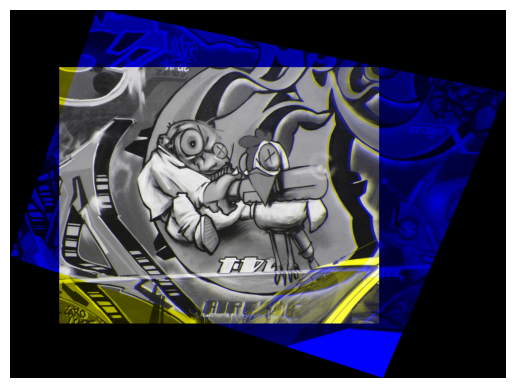

In [3]:
# load images
img1, img2 =  cv2.imread("images\img1.jpg", flags=0),  cv2.imread("images\img2.jpg", flags=0)
# extract matching points with SIFT
pts1, pts2 = extract_and_match_SIFT(img1, img2, num=100)
# find best homography H
H = find_final_homography(pts1, pts2, niter = 100, thresh = 1.0)
# draw homography
draw_homography(img1, img2, H)

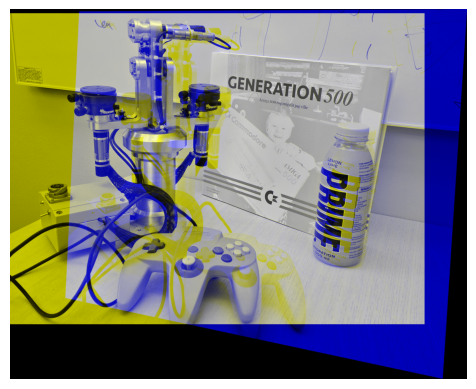

In [14]:
# load images
img1, img2 =  cv2.imread("images\desk1.jpg", flags=0),  cv2.imread("images\desk2.jpg", flags=0)
# extract matching points with SIFT
pts1, pts2 = extract_and_match_SIFT(img1, img2, num=100)
# find best homography H
H = find_final_homography(pts1, pts2, niter = 10000, thresh = 1.0)
# draw homography
draw_homography(img1, img2, H)

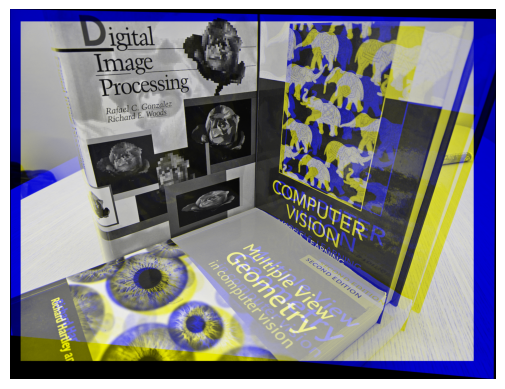

In [23]:
# load images
img1, img2 =  cv2.imread("images/books1.jpg", flags=0),  cv2.imread("images/books2.jpg", flags=0)
# extract matching points with SIFT
pts1, pts2 = extract_and_match_SIFT(img1, img2, num=100)
# find best homography H
H = find_final_homography(pts1, pts2, niter = 10000, thresh = 1.0)
# draw homography
draw_homography(img1, img2, H)

The overlap is not as good as in the flat case, it is incomplete or misaligned. Some regions, 
particularly flat ones, overlap quite well while the others do not align correctly. 

However, the results can still be exploitable because they allow to identify planar and non
planar regions. If there is no overlap, it means that there is some depth variation in the region. 
If combined with some 3D reconstruction techniques, it can be useful. 

The overlap is not as good as in the flat case, it is incomplete or misaligned. Some regions, particularly flat ones, overlap quite well while the others do not align correctly.

However, the results can still be exploitable because they allow to identify planar and non-planar regions. If there is no overlap, it means that there is some depth variation in the region. If combined with some 3D reconstruction techniques, it can be useful.

## 2) Image matching with fundamental matrices

When the world is not flat, we can no longer use a homography to relate matching image points between the two images. **An alternative is instead to use the so-called epipilar constraint, according to which an image feature in one image can find its corresponding match in the other image along a particular line, known as the epipolar line.**

**Two matching image points xa and xb can be related through the epipolar constraint $x_b^\top F x_a =0$ where $F$ is a fundamental matrix that can be written in terms of four components: $F=K_b^{-\top}R[t]_× K_a^{-1}$.**

In this equation $K_a$ and $K_b$ are the respective camera matrices, $R$ is the relative rotation expressed as a rotation matrix between the coordinate systems of the two cameras, and *t* is the relative translation (difference between the two optical centers. $[t]_×$ denotes a skew-symmetric matrix that corresponds to what happens when you do a cross product with $t$, i.e. $[t]_×x=t×x$,but written in a more convenient matrix form.

Fully recovering the exact camera matrices is very difficult -> we assume a more simple form where only the focal length is needed.

The only difference is in the implementation of the matrix since $B$ does not have the same size and the same elements as $A$.

### Effect of outliers

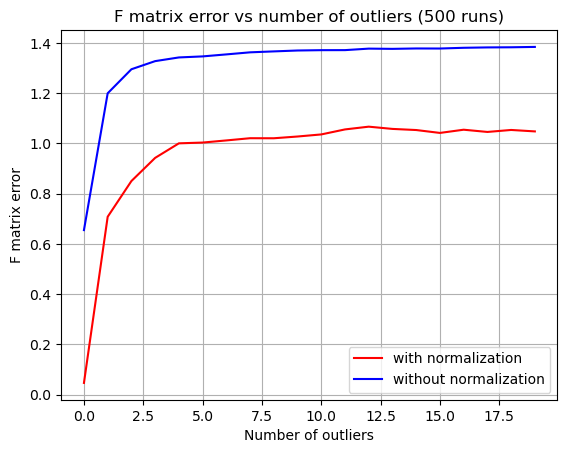

In [10]:
outliers_list = np.arange(0, 20, 1).tolist()
N_runs = 500
err_run = np.zeros((N_runs, len(outliers_list)))
err_run_not_norm = np.zeros((N_runs, len(outliers_list)))

for n in range(N_runs):
    for noutliers in outliers_list:
        pts1, pts2, F_1 = generate_3d_points(100, noutliers = noutliers, noise = 0.5, vergence = 10.0, focal = 1000)

        # with normalization
        F_2 = find_fmatrix(pts1, pts2, normalize = True)
        err_run[n, outliers_list.index(noutliers)] = fmatrix_error(F_1, F_2, focal = 1000)

        # without normalization
        F_2_not_norm = find_fmatrix(pts1, pts2)
        err_run_not_norm[n, outliers_list.index(noutliers)] = fmatrix_error(F_1, F_2_not_norm, focal = 1000)

err = np.mean(err_run, axis=0)
err_not_norm = np.mean(err_run_not_norm, axis=0)

plt.plot(outliers_list, err, label='with normalization', color='r')
plt.plot(outliers_list, err_not_norm, label='without normalization', color='b')
plt.title(f"F matrix error vs number of outliers ({N_runs} runs)")
plt.xlabel('Number of outliers')
plt.ylabel('F matrix error')
plt.legend()
plt.grid()
plt.show()

The error becomes significant since 1 outlier and increases quite quickly. With normalization, the error values are consistently lower.

### Filtering using RANSAC

Again, we use RANSAC to filter out the outliers. We compute a distance error to measure whether points lie along the epipolar line or not.

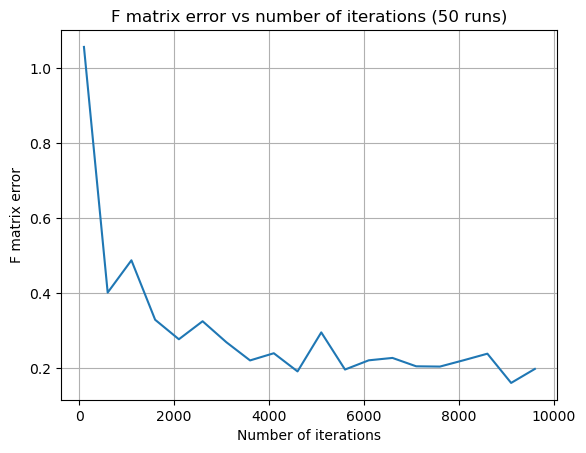

In [36]:
iterations_list = np.arange(100, 10000, 500).tolist()
N_runs = 50
noutliers = 50
thresh = 1.0
err_run = np.zeros((N_runs, len(iterations_list)))
err_run_RANSAC = np.zeros((N_runs, len(iterations_list)))

for n in range(N_runs):
    for niter in iterations_list:
        pts1, pts2, F_1 = generate_3d_points(100, noutliers = noutliers, noise = 0.5, vergence = 10.0, focal = 1000)

        F_2_RANSAC = find_final_fmatrix(pts1, pts2, niter = niter, thresh = thresh)
        err_run_RANSAC[n, iterations_list.index(niter)] = fmatrix_error(F_1, F_2_RANSAC, focal=1000)

err_RANSAC = np.mean(err_run_RANSAC, axis=0)

plt.plot(iterations_list, err_RANSAC)
plt.title(f"F matrix error vs number of iterations ({N_runs} runs)")
plt.xlabel('Number of iterations')
plt.ylabel('F matrix error')
plt.grid()
plt.show()

The error is getting small enough around 5000 iterations. We need much more iterations than with the homography because each minimum set is here composed of 8 points instead of 4.

### Results

Part of all pairs classified as inliers: 74.0%


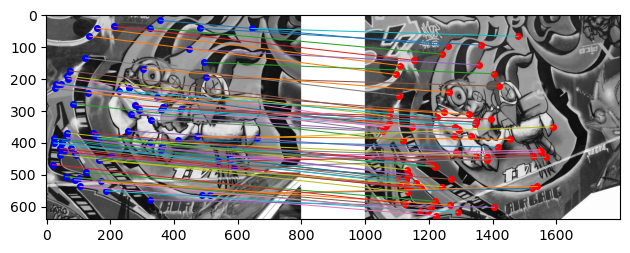

In [19]:
# load images
img1, img2 =  cv2.imread("images\img1.jpg", flags=0),  cv2.imread("images\img2.jpg", flags=0)
# extract matching points with SIFT
pts1, pts2 = extract_and_match_SIFT(img1, img2, num=100)
length = pts1.shape[1]
# remove outliers using RANSAC
niter = 10000
thresh = 1.0
F, n_inliers, errors = find_fmatrix_RANSAC(pts1, pts2, niter = niter, thresh = thresh)
indices_to_remove = []
for i in range(len(errors)):
    if errors[i] > thresh:
        indices_to_remove.append(i)
new_pts1, new_pts2 = np.delete(pts1, indices_to_remove, axis=1), np.delete(pts2, indices_to_remove, axis=1)
new_length = new_pts1.shape[1]
# compute fraction of inliers
print(f"Part of all pairs classified as inliers: {n_inliers/length * 100}%")
# draw homography
draw_matches(new_pts1, new_pts2, img1 = img1, img2 = img2)

Part of all pairs classified as inliers: 83.0%


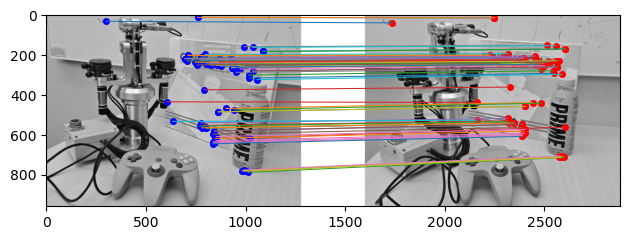

In [18]:
# load images
img1, img2 =  cv2.imread("images\desk1.jpg", flags=0),  cv2.imread("images\desk2.jpg", flags=0)
# extract matching points with SIFT
pts1, pts2 = extract_and_match_SIFT(img1, img2, num=100)
length = pts1.shape[1]
# remove outliers using RANSAC
niter = 10000
thresh = 1.0
F, n_inliers, errors = find_fmatrix_RANSAC(pts1, pts2, niter = niter, thresh = thresh)
indices_to_remove = []
for i in range(len(errors)):
    if errors[i] > thresh:
        indices_to_remove.append(i)
new_pts1, new_pts2 = np.delete(pts1, indices_to_remove, axis=1), np.delete(pts2, indices_to_remove, axis=1)
# compute fraction of inliers
print(f"Part of all pairs classified as inliers: {n_inliers/length * 100}%")
# draw homography
draw_matches(new_pts1, new_pts2, img1 = img1, img2 = img2)

Part of all pairs classified as inliers: 97.0%


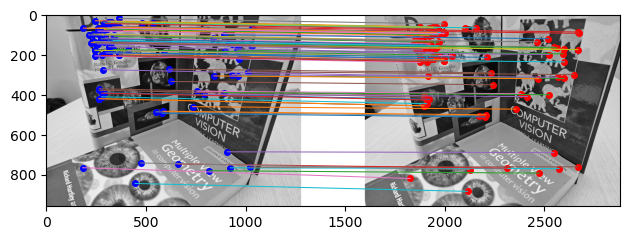

In [20]:
# load images
img1, img2 =  cv2.imread("images/books1.jpg", flags=0),  cv2.imread("images/books2.jpg", flags=0)
# extract matching points with SIFT
pts1, pts2 = extract_and_match_SIFT(img1, img2, num=100)
length = pts1.shape[1]
# remove outliers using RANSAC
niter = 10000
thresh = 1.0
F, n_inliers, errors = find_fmatrix_RANSAC(pts1, pts2, niter = niter, thresh = thresh)
indices_to_remove = []
for i in range(len(errors)):
    if errors[i] > thresh:
        indices_to_remove.append(i)
new_pts1, new_pts2 = np.delete(pts1, indices_to_remove, axis=1), np.delete(pts2, indices_to_remove, axis=1)
new_length = new_pts1.shape[1]
# compute fraction of inliers
print(f"Part of all pairs classified as inliers: {new_length/length * 100}%")
# draw homography
draw_matches(new_pts1, new_pts2, img1 = img1, img2 = img2)

Part of all pairs classified as inliers: 28.999999999999996%


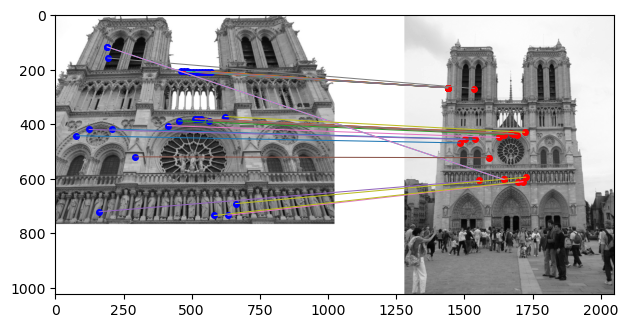

In [21]:
# load images
img1, img2 =  cv2.imread("images/notredame1.jpg", flags=0),  cv2.imread("images/notredame2.jpg", flags=0)
# extract matching points with SIFT
pts1, pts2 = extract_and_match_SIFT(img1, img2, num=100)
length = pts1.shape[1]
# remove outliers using RANSAC
niter = 10000
thresh = 1.0
F, n_inliers, errors = find_fmatrix_RANSAC(pts1, pts2, niter = niter, thresh = thresh)
indices_to_remove = []
for i in range(len(errors)):
    if errors[i] > thresh:
        indices_to_remove.append(i)
new_pts1, new_pts2 = np.delete(pts1, indices_to_remove, axis=1), np.delete(pts2, indices_to_remove, axis=1)
new_length = new_pts1.shape[1]
# compute fraction of inliers
print(f"Part of all pairs classified as inliers: {new_length/length * 100}%")
# draw homography
draw_matches(new_pts1, new_pts2, img1 = img1, img2 = img2)

The fraction of pairs classified as inliers is highly dependent on the image. For most of the images, it ranges from 75\% to 97\% and I don't see any obvious remaining mismatch. However, for the most "complex" image, the fraction is only 29 \% and some remaining obvious outliers are still observable.

## 3) Extracting projection matrices

Our ultimate goal is not just to find a fundamental matrix F, but to recover the projection matrices of the respective cameras and finally a 3D reconstruction of the observed points in the world.

### Recovering projection matrices $M$

To compute $R$ and $t$, we perform SVD on $\hat{F}'=K_b^\top \hat{F} K_a= \hat{R}\hat{[t]}_X$ (in image coordinates and not anymore in pixel coordinates) -> gives us expressions of $\hat{R}$ and $\hat{[t]}_X$ + a condition: **for a correct fundamental matrix, one of the singular values should be 0 and the other two should be equal** but because of approximations, we will only check if two similar in scale and larger than the third one

Another problem: four possible solutions because two possible rotation matrices and two possible translation matrices  (because of the transposes) -> we reconstruct for all of them and check which one is the right one (the one with points in front of both cameras)

### Reconstructing 3D images with triangulation

At this point, we have the projection matrices $M_a$ and we want $X$ in 3D such that $x_a \approx M_a X$ -> gives us a line but the object might by anywhere on the line -> To get it, we need another camera and corresponding image point such that $x_b \approx M_b X$ (can be re-written as $GX=0$)

We are trying to find the intersection point of two projection lines, one for each camera, but the two lines might not at all intersect. The alternative is to find a 3D point that lies as close as possible to the two lines -> again least square minimization under the same condition for the scale in homogeneous coordinates -> Lagrange -> eigenvector of the smallest eigenvalue of $G^\top G$

### Implementation

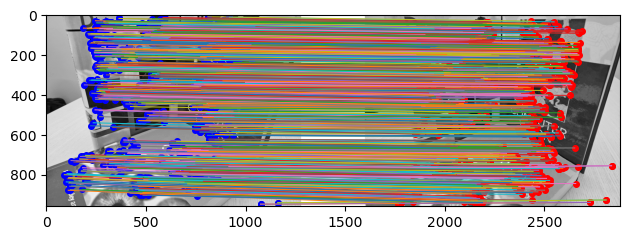


number of features:  1000
number of inliers:  931
initial F = 
 [[-1.45377799e-06  3.05880418e-06 -2.03167529e-02]
 [ 3.85641705e-06 -1.17464651e-06  8.98534409e-02]
 [ 2.41633759e-02 -8.92873709e-02 -9.91442124e-01]]
final F = 
 [[-1.35649974e-06  1.15051141e-06 -1.94730752e-02]
 [ 5.62918992e-06 -1.15079458e-06  8.86035169e-02]
 [ 2.32076730e-02 -8.79792113e-02 -9.91711288e-01]]
projection M = 
 [[ 9.96654846e+02  4.17462942e+01 -7.02592722e+01  9.76637199e+02]
 [-4.14335985e+01  9.99123824e+02  5.90271389e+00  2.14678456e+02]
 [ 7.04441292e-02 -2.97187393e-03  9.97511300e-01  9.64069652e-03]]
rotation angle =  4.694684342867313


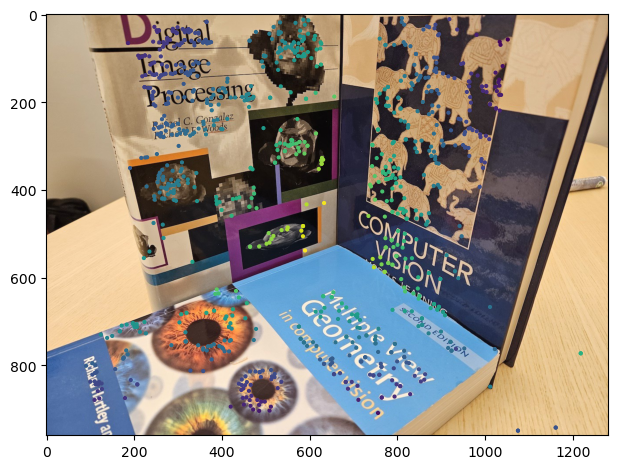

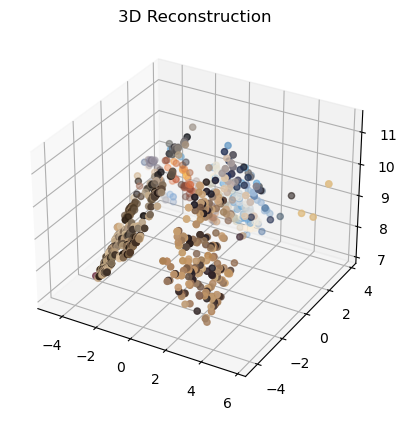

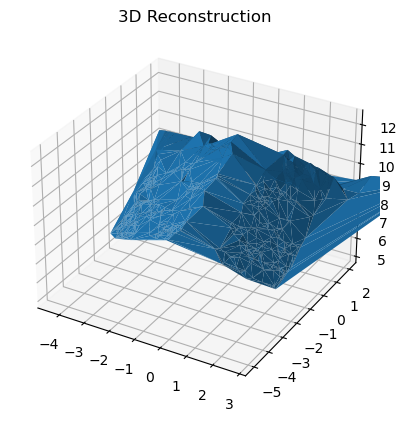

In [31]:
focal = 1000
run_triangulation("images/books1.jpg", "images/books2.jpg", focal)

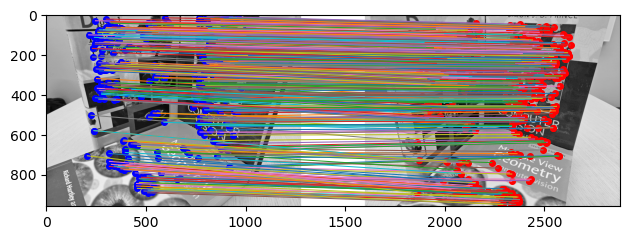


number of features:  1000
number of inliers:  469
initial F = 
 [[ 9.13979709e-07 -7.86232739e-06 -6.08412211e-04]
 [-7.89474288e-06  3.71133698e-07 -3.11775205e-02]
 [-5.25891914e-03  3.12068007e-02  9.99012548e-01]]
final F = 
 [[ 9.08271163e-07 -7.50443540e-06 -5.68873661e-04]
 [-8.22884598e-06  2.93284810e-07 -3.12712896e-02]
 [-5.27727370e-03  3.12568073e-02  9.99007980e-01]]
projection M = 
 [[ 8.66947079e+02  1.74383530e+02 -4.66897361e+02  9.72574196e+02]
 [-1.73358830e+02  9.83804888e+02  4.55484226e+01 -1.22906495e+01]
 [ 4.67278801e-01  4.14527081e-02  8.83137699e-01  2.32267893e-01]]
rotation angle =  29.894472784204517


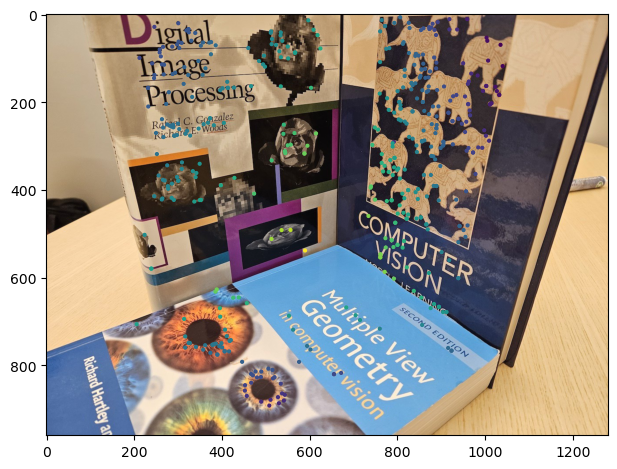

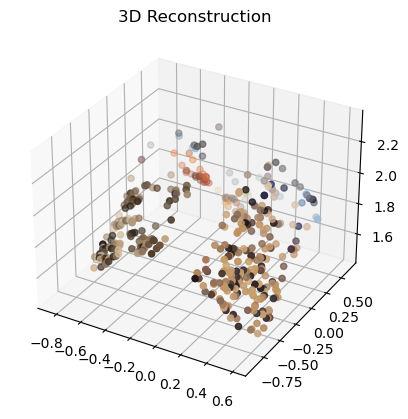

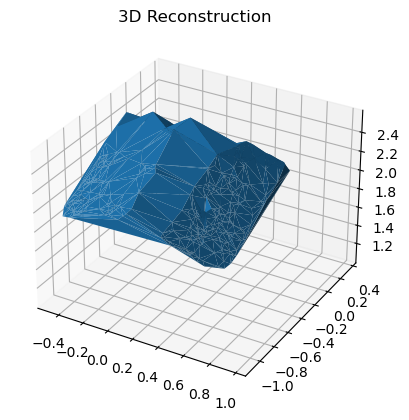

In [30]:
focal = 1000
run_triangulation("images/books1.jpg", "images/books5.jpg", focal)

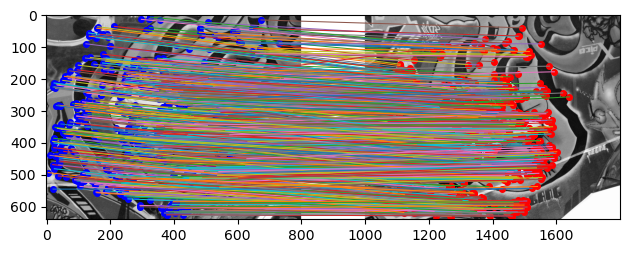


number of features:  1000
number of inliers:  759
initial F = 
 [[ 2.47808394e-05 -6.88374745e-05  3.59831048e-02]
 [ 6.67366915e-05  2.20484499e-05  4.62210526e-02]
 [-1.79653867e-02 -5.31373624e-02 -9.96705817e-01]]
final F = 
 [[ 2.46521261e-05 -6.84918798e-05  3.58072042e-02]
 [ 6.62881814e-05  2.20688204e-05  4.59932258e-02]
 [-1.78639164e-02 -5.28910714e-02 -9.96737615e-01]]
projection M = 
 [[ 9.40134858e+02  3.39735945e+02  2.69432082e+01 -4.80460417e+02]
 [-3.40108978e+02  9.40326252e+02  1.06029964e+01  3.90566887e+02]
 [-2.17331870e-02 -1.91318735e-02  9.99580732e-01  7.85248556e-01]]
rotation angle =  19.944929899926134


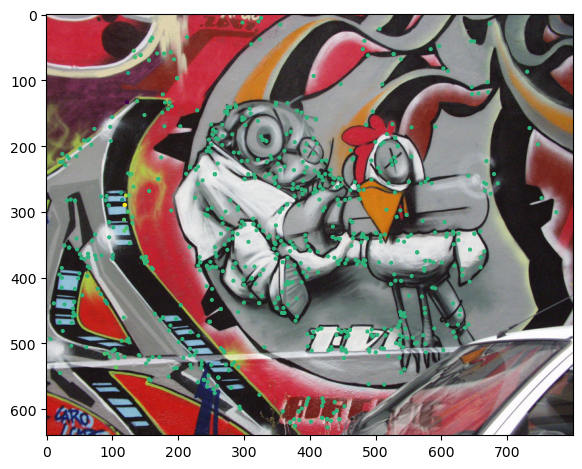

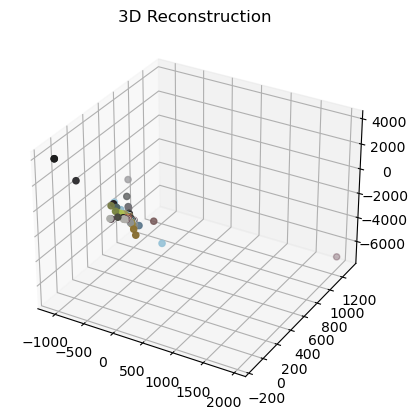

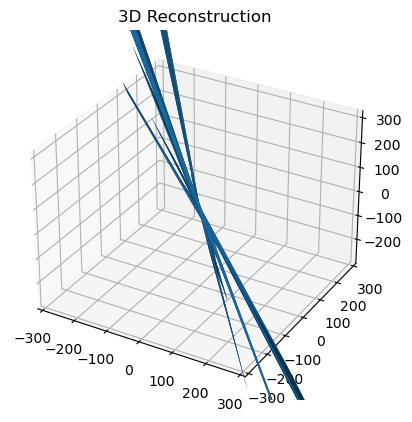

In [32]:
focal = 1000
run_triangulation("images\img1.jpg", "images\img2.jpg", focal)

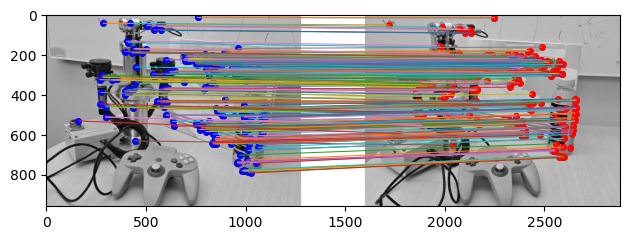


number of features:  817
number of inliers:  287
initial F = 
 [[-2.16032608e-05  1.11833210e-04 -5.16212098e-02]
 [ 2.67549284e-05  8.58867069e-06  6.85380584e-01]
 [ 1.26466629e-01 -6.52584679e-01 -2.92793648e-01]]
final F = 
 [[ 2.40865161e-05 -1.23492159e-04  5.01214968e-02]
 [-2.17621146e-05 -7.40298275e-06 -7.14453920e-01]
 [-1.27976302e-01  6.80275079e-01  8.88329761e-02]]
projection M = 
 [[ 9.71334536e+02  1.12068473e+02 -2.09642261e+02  9.81488503e+02]
 [-1.16892843e+02  9.93086624e+02 -1.07247192e+01  6.88441352e+01]
 [ 2.06991022e-01  3.49229701e-02  9.77719337e-01  1.78719905e-01]]
rotation angle =  13.815371916644814


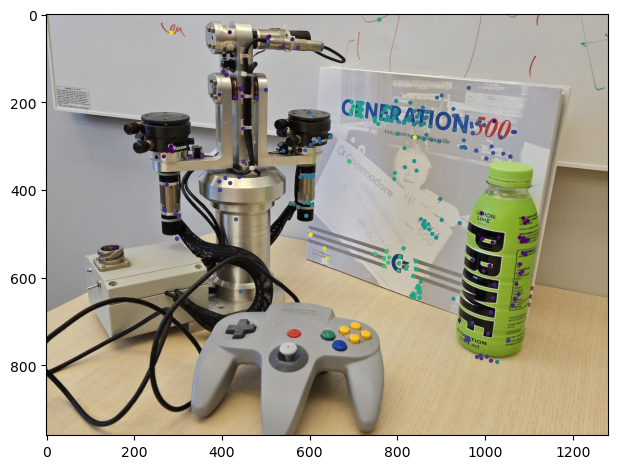

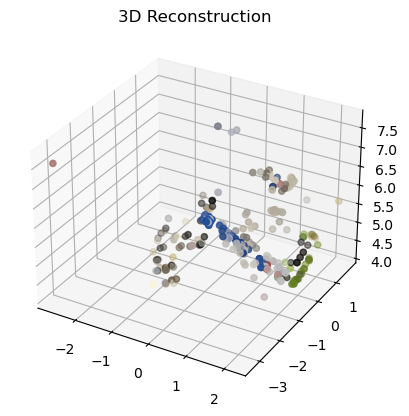

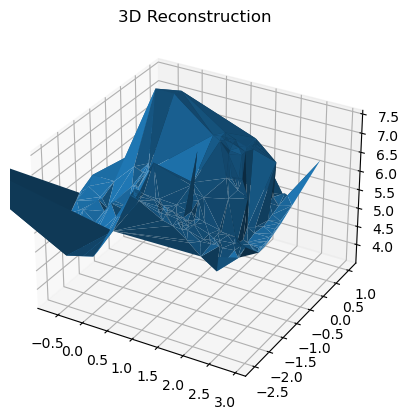

In [33]:
focal = 1000
run_triangulation("images\desk1.jpg", "images\desk2.jpg", focal)

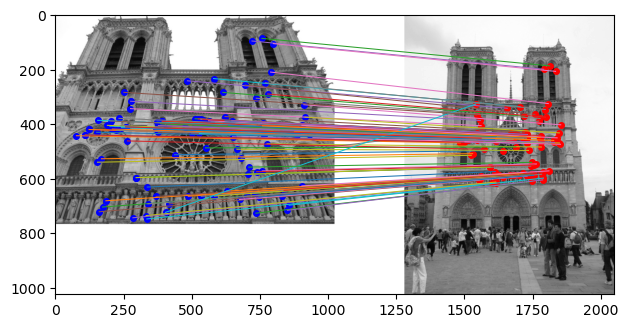


number of features:  1000
number of inliers:  108
initial F = 
 [[ 2.63726146e-06 -1.24084830e-04  9.70729867e-02]
 [ 1.42886485e-04 -1.16110954e-06 -3.15801200e-03]
 [-3.20071859e-02  2.15076048e-03 -9.94755116e-01]]
final F = 
 [[-2.34060189e-06  1.25228647e-04 -9.83046197e-02]
 [-1.44686130e-04  1.33503630e-06  3.18932410e-03]
 [ 3.24376127e-02 -2.16450538e-03  9.94620083e-01]]
projection M = 
 [[ 9.99933973e+02  2.48817398e+00 -1.12186769e+01  1.54604412e+01]
 [-7.07898275e+00  9.02413370e+02 -4.30813182e+02  2.18470234e+02]
 [ 9.05194587e-03  4.30864153e-01  9.02371400e-01  9.75721134e-01]]
rotation angle =  25.53004971808242


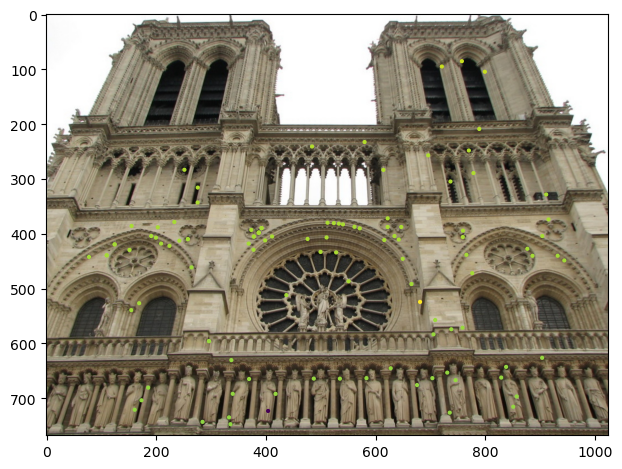

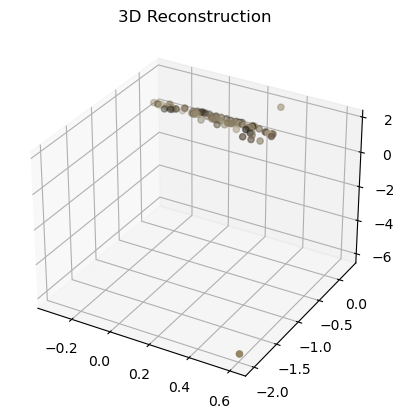

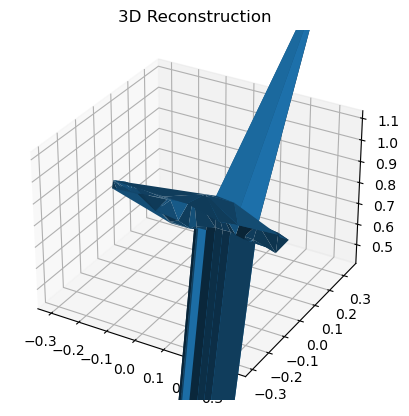

In [34]:
focal = 1000
run_triangulation("images/notredame1.jpg", "images/notredame2.jpg", focal)

If we assume the angle between two books in books1.jpg is 90◦, it is possible to tell approximately how large the real focal length is by:
- extracting the 3D points corresponding to each book
- approximating each book with a plane
- computing normal vectors for each plane 
- iteratively changing the focal length until the angle between the normal vectors is 90°

The reconstruction looks quite robust to the choice of images and the characteristics of the 3D scenes. It handles the scenes with flat surfaces quite well and is effective regardless of both the rotation angle and the scale change.

To further improve 3D reconstructions, one could consider using bundle adjustment with multiple cameras. The computation of fundamental matrices and triangulation between pairs of images (what has been done so far) could be used to roughly initialize the camera poses and 3D points. Then, bundle adjustment could optimize the entire system (camera positions and 3D points) simultaneously, iterating to find the best configuration that minimizes reprojection errors.